# NGC 4567 Analysis

Isaac Cheng - November 2021

Based on the [NGC4380 notebook](../NGC4380/NGC4380.ipynb).

This is meant to be a compilation/walkthrough of how to generate many of the different
plots and data products related to the analysis of a galaxy using NGVS and VERTICO data.
Additionally, this notebook can act as a template for the analysis of other galaxies.

Note that these cells should be run sequentially, as subsequent cells may rely on data
from previous cells. I have tried my best to keep each section as self-contained as
possible, but there are some cells which would be impractical to run every time.

Finally, throughout all of these analyses, we assume a distance of 16.5 Mpc (the distance
to the centre of the Virgo cluster) with a 10% distance uncertainty. This distance
uncertainty is a systematic error and does not affect our analyses or interpretation of
the resolved data. Thus, unless specifically noted, all derived uncertainties only include
random errors and do not account for the distance uncertainty.


# Bin NGVS Data (1. to specific extent & resolution, 2. using adaptive binning)


## 2. Voronoi (adaptive) binning procedure

The difficulty lies in:
1. Ensuring the *exact same* Voronoi binning pattern occurs across all optical bands
2. Reducing the runtime of Voronoi binning for large images

Here is a basic 4-step method that aims to solve item 1 above:
1. Choose a target SNR (e.g., target_snr=50) and run Voronoi binning on one file. Call the
   resulting binning "bin0".
2. Apply the same Voronoi binning (bin0) to the other band(s). If all of the pixels have
   an SNR > target_snr, we are done.
3. If not all the pixels meet the required SNR, re-run Voronoi binning with
   target_snr=target_snr + (some value). That is, we are increasing the target SNR by
   some value. Call the resulting binning "bin1".
4. Apply this new Voronoi binning to the other band(s). If all the pixels have an SNR >
   the original target_snr (e.g., 50), we are done. Else, repeat steps 3 & 4.
   - In principle, this is easy. In testing, despite setting a target_snr of 30, for
     example, many points (not near the edges) will have SNRs of ~25 as well. Thus, this
     may require a manual check. Also see the 2 strategies below.

There are 2 easy strategies to help speed up the 4-step method above:
1. Choose an initial target_snr greater than the SNR we really want/need (e.g., setting a
   target_snr=35 when we need a minimum SNR of 30). Once an automated function is
   implemented, we could take these inputs as two different parameters (e.g.,
   initial_snr=35 and wanted_snr=30) in an attempt to minimize the number of Voronoi
   binning iterations. Another approach instead of naively checking if all SNR >
   target_snr is by allowing some percentage (e.g., 1%) of pixels to lie below the
   target_snr and still count this as a success.
2. Run Voronoi binning on the image that has the lowest SNR (e.g., u- or z-band data).
   This will help maximize the chance that all the other bands meet the target_snr using
   the same Voronoi binning pattern.

Regarding difficulty #2, here is an excerpt from the `vorbin` documentation (slightly
modified for myself):
> As for many other computational problems, a way to radically decrease the computation
> time consists of proceeding in a hierarchical manner. Suppose for example we have a
> 4000x4000 pixel image, we can do the following:
>> 1. Rebin the image regularly (e.g. in groups of 8x8 pixels) to a manageable size of
>>    500x500 pixels;
>> 2. Apply the standard Voronoi 2D-binning procedure to the 500x500 image;
>> 3. Transform all unbinned pixels (which already have enough S/N) of the 500x500 Voronoi
>>    2D-binned image back into their original individual full-resolution pixels;
>> 4. Now apply Voronoi 2D-binning only to the connected regions of full-resolution
>>    pixels (i.e., the "subpixels" of step 2's unbinned pixels);
>> 5. Merge the set of lower resolution bins with the higher resolution ones.

In practice, I still have to write a function to do this. I did not bother to do it with
the current galaxy since I just let Voronoi binning run overnight.


In [1]:
# Need to switch directories if using VS Code + sshfs
GALAXY = "NGC4567"
GALPATH = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{GALAXY}/"
%cd "$GALPATH"
# 
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import reproject
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import fast_vorbin as fv
# # Reload my packages
# import importlib
# importlib.reload(fu)
# importlib.reload(pu)
# importlib.reload(fv)
# 
GALDIST = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty

/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4567


In [2]:
# 
# Just in case, run Voronoi-binning with small sample first
# 
tmpnumpx = 200
tmpx = np.arange(1, tmpnumpx + 1).astype(int)
tmpy = np.arange(1, tmpnumpx + 1).astype(int)
tmpx, tmpy = np.meshgrid(tmpx, tmpy)
tmpsig = np.full(tmpx.size, 0.5)
tmpnoise = np.full(tmpx.size, 1.0)
# 
_ = fv.voronoi_2d_binning(
    tmpx.flatten(),
    tmpy.flatten(),
    tmpsig.flatten(),
    tmpnoise.flatten(),
    targetSN=10,
    pixelsize=1,
    cvt=False,
    quiet=True,
    wvt=False,
    sn_func=None,
    plot=False,
)

Compiling bin accretion algorithm
Compiling voronoi tesselation algorithm
Bin-accretion done in 0.10 minutes
It took 0.12 minutes to finish Voronoi-binning!


In [3]:
bin_resolution = "vorbin"
# 
# Load data
# N.B. Need to update NGVS paths
# 
# Signal
zband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_data.fits"
iband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_i_data.fits"
gband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_g_data.fits"
uband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_u_data.fits"
# Noise (sigma maps)
znoise_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_sig.fits"
inoise_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_i_sig.fits"
gnoise_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_g_sig.fits"
unoise_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_u_sig.fits"
# Mask (flag maps)
zgood_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_flag.fits"
igood_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_flag.fits"
ggood_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_flag.fits"
ugood_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_flag.fits"
# 
# Load NGVS data
# 
# Signal
zband_data_full, zband_header_full = fits.getdata(zband_path, header=True)
iband_data_full, iband_header_full = fits.getdata(iband_path, header=True)
gband_data_full, gband_header_full = fits.getdata(gband_path, header=True)
uband_data_full, uband_header_full = fits.getdata(uband_path, header=True)
# Noise
zband_noise_full = fits.getdata(znoise_path)
iband_noise_full = fits.getdata(inoise_path)
gband_noise_full = fits.getdata(gnoise_path)
uband_noise_full = fits.getdata(unoise_path)
# Masks
zband_good_full = fits.getdata(zgood_path, ext=1)
iband_good_full = fits.getdata(igood_path, ext=1)
gband_good_full = fits.getdata(ggood_path, ext=1)
uband_good_full = fits.getdata(ugood_path, ext=1)
# 
# VERTICO CO Data (only to cut out the NGVS data to the same extent as the VERTICO data)
# 
# 9 arcsec beam, 2 arcsec pixels. Units of K.km/s
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{GALAXY}/{GALAXY}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
Ico_data, co_header = fits.getdata(Ico_path, header=True)
co_wcs = WCS(co_header)
#
# Mask the data and noise arrays
#
# Only choose pixels with sensible (i.e., positive) SNR
# my_mask = (uband_data_full/uband_noise_full < 0) | (gband_data_full/gband_noise_full < 0) | (iband_data_full/iband_noise_full < 0) | (zband_data_full/zband_noise_full < 0)
my_mask = np.zeros_like(uband_data_full).astype(bool)
uband_data_masked = np.ma.masked_array(uband_data_full, mask=(uband_good_full == 0) | my_mask).filled(fill_value=np.nan)
uband_noise_masked = np.ma.masked_array(uband_noise_full, mask=(uband_good_full == 0) | my_mask).filled(fill_value=np.nan)
gband_data_masked = np.ma.masked_array(gband_data_full, mask=(gband_good_full == 0) | my_mask).filled(fill_value=np.nan)
gband_noise_masked = np.ma.masked_array(gband_noise_full, mask=(gband_good_full == 0) | my_mask).filled(fill_value=np.nan)
iband_data_masked = np.ma.masked_array(iband_data_full, mask=(iband_good_full == 0) | my_mask).filled(fill_value=np.nan)
iband_noise_masked = np.ma.masked_array(iband_noise_full, mask=(iband_good_full == 0) | my_mask).filled(fill_value=np.nan)
zband_data_masked = np.ma.masked_array(zband_data_full, mask=(zband_good_full == 0) | my_mask).filled(fill_value=np.nan)
zband_noise_masked = np.ma.masked_array(zband_noise_full, mask=(zband_good_full == 0) | my_mask).filled(fill_value=np.nan)
# 
# Cutout the data and noise to the same extent as the VERTICO data
# 
uband_data, uband_wcs = fu.cutout_to_target(uband_data_masked, WCS(uband_header_full), Ico_data, co_wcs)
gband_data, gband_wcs = fu.cutout_to_target(gband_data_masked, WCS(gband_header_full), Ico_data, co_wcs)
iband_data, iband_wcs = fu.cutout_to_target(iband_data_masked, WCS(iband_header_full), Ico_data, co_wcs)
zband_data, zband_wcs = fu.cutout_to_target(zband_data_masked, WCS(zband_header_full), Ico_data, co_wcs)
uband_noise, uband_wcs = fu.cutout_to_target(uband_noise_masked, WCS(uband_header_full), Ico_data, co_wcs)
gband_noise, gband_wcs = fu.cutout_to_target(gband_noise_masked, WCS(gband_header_full), Ico_data, co_wcs)
iband_noise, iband_wcs = fu.cutout_to_target(iband_noise_masked, WCS(iband_header_full), Ico_data, co_wcs)
zband_noise, zband_wcs = fu.cutout_to_target(zband_noise_masked, WCS(zband_header_full), Ico_data, co_wcs)
print("Array shape:", uband_data.shape)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Array shape: (667, 668)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


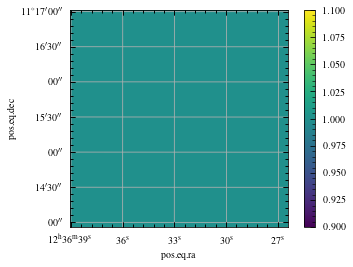

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": WCS(zband_header_full)})
img = ax.imshow(zband_good_full)
fig.colorbar(img)
ax.set_aspect("equal")
plt.show()

mean u: 33.094414
mean g: 78.06931
mean i: 62.3191
mean z: 45.086063

median u: 30.798445
median g: 75.73745
median i: 58.851715
median z: 39.956932


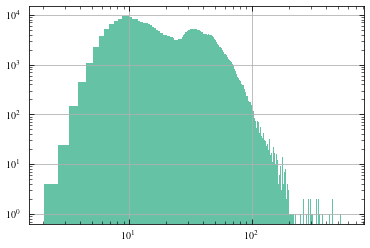

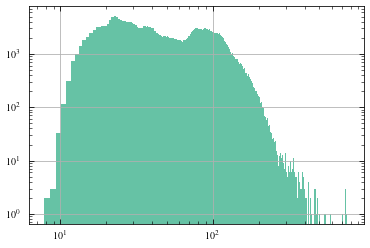

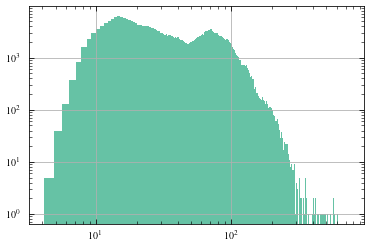

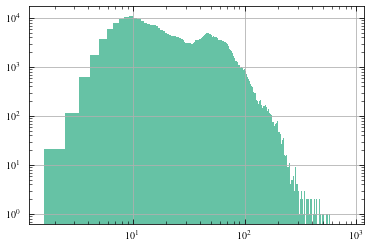

In [5]:
print("mean u:", np.nanmean(uband_data/uband_noise))
print("mean g:", np.nanmean(gband_data/gband_noise))
print("mean i:", np.nanmean(iband_data/iband_noise))
print("mean z:", np.nanmean(zband_data/zband_noise))
print()
print("median u:", np.nanmedian(uband_data/uband_noise))
print("median g:", np.nanmedian(gband_data/gband_noise))
print("median i:", np.nanmedian(iband_data/iband_noise))
print("median z:", np.nanmedian(zband_data/zband_noise))
fig, ax = plt.subplots()
ax.hist(uband_data.flatten() / uband_noise.flatten(), bins=1000)
# ax.set_xlim(left=1e-6)
ax.loglog()
# ax.set_xlim(right=1e-6)
# ax.semilogy()
plt.show()
fig, ax = plt.subplots()
ax.hist(gband_data.flatten() / gband_noise.flatten(), bins=1000)
# ax.set_xlim(left=1e-6)
ax.loglog()
# ax.set_xlim(right=1e-6)
# ax.semilogy()
plt.show()
fig, ax = plt.subplots()
ax.hist(iband_data.flatten() / iband_noise.flatten(), bins=1000)
# ax.set_xlim(left=1e-6)
ax.loglog()
# ax.set_xlim(right=1e-6)
# ax.semilogy()
plt.show()
fig, ax = plt.subplots()
ax.hist(zband_data.flatten() / zband_noise.flatten(), bins=1000)
# ax.set_xlim(left=1e-6)
ax.loglog()
# ax.set_xlim(right=1e-6)
# ax.semilogy()
plt.show()

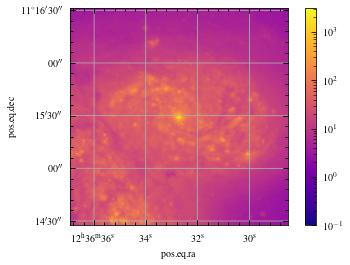

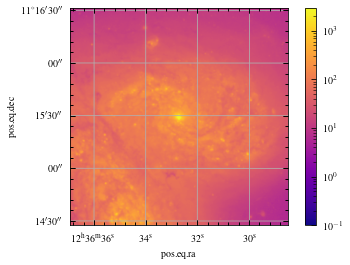

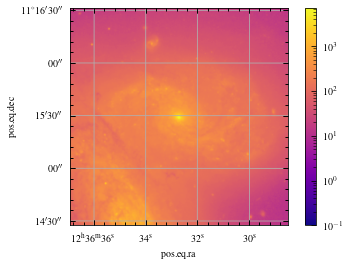

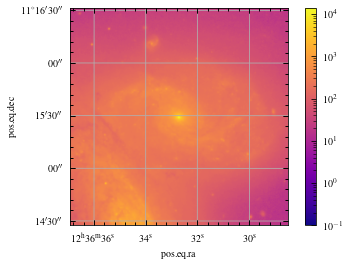

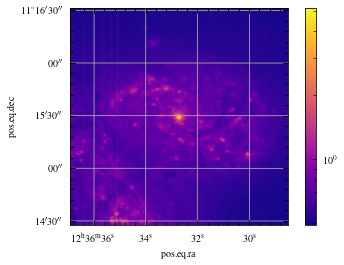

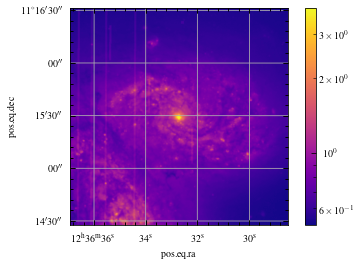

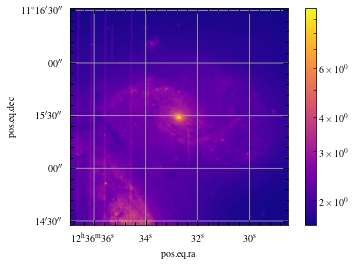

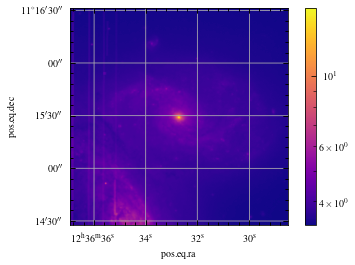

In [6]:
# 
# This cell shows the image if I only use the flag mask!
# 
fig, ax = plt.subplots(subplot_kw={"projection": uband_wcs})
img = ax.imshow(uband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": gband_wcs})
img = ax.imshow(gband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": iband_wcs})
img = ax.imshow(iband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": zband_wcs})
img = ax.imshow(zband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": uband_wcs})
img = ax.imshow(uband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": gband_wcs})
img = ax.imshow(gband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": iband_wcs})
img = ax.imshow(iband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": zband_wcs})
img = ax.imshow(zband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()

In [ ]:
# 
# This cell shows the image after I mask out SNR < 0!
# 
fig, ax = plt.subplots(subplot_kw={"projection": uband_wcs})
img = ax.imshow(uband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": gband_wcs})
img = ax.imshow(gband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": iband_wcs})
img = ax.imshow(iband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": zband_wcs})
img = ax.imshow(zband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": uband_wcs})
img = ax.imshow(uband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": gband_wcs})
img = ax.imshow(gband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": iband_wcs})
img = ax.imshow(iband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": zband_wcs})
img = ax.imshow(zband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()

Reference data array shape: (667, 668)
Number of pixels to Voronoi-bin: 445556
Compiling bin accretion algorithm
Compiling voronoi tesselation algorithm
Bin-accretion done in 72.26 minutes
It took 72.27 minutes to finish Voronoi-binning!


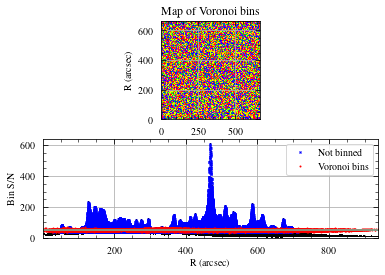

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4567/NGC4567_vorbin_SNR50_In+Out.pkl


In [7]:
import dill
%matplotlib inline
# 
# Specify reference arrays for Voronoi binning.
# The resulting binning pattern will be applied across all bands
# 
ref_data = uband_data
ref_noise = uband_noise
ref_wcs = uband_wcs
print("Reference data array shape:", np.shape(ref_data))
# 
# Voronoi binning preparation
# 
SNR_TARGET = 50
#
y_coords, x_coords = np.meshgrid(
    np.arange(ref_data.shape[0]), np.arange(ref_data.shape[1])
)
x_coords, y_coords = x_coords.T, y_coords.T
isgood_vorbin = np.isfinite(ref_data) & np.isfinite(ref_noise)
# 
# Voronoi binning of reference data and noise
# 
print("Number of pixels to Voronoi-bin:", np.sum(np.isfinite(x_coords[isgood_vorbin])))
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = fv.voronoi_2d_binning(
    x_coords[isgood_vorbin],
    y_coords[isgood_vorbin],
    ref_data[isgood_vorbin],
    ref_noise[isgood_vorbin],
    targetSN=SNR_TARGET,
    pixelsize=1,
    cvt=False,
    quiet=True,
    wvt=False,
    sn_func=None,
)
# 
# Save inputs and raw outputs of Voronoi binning
# 
vorbin_outfile = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_In+Out.pkl"
with open(vorbin_outfile, "wb") as f:
    dill.dump(
        {
            # "full_shape": np.shape(data_u_cut),  # same as isgood_vorbin.shape
            "x_coords": x_coords,
            "y_coords": y_coords,
            "signal": ref_data,
            "noise": ref_noise,
            "isgood_vorbin": isgood_vorbin,
            "snr_target": SNR_TARGET,
            "binNum": binNum,
            "xNode": xNode,
            "yNode": yNode,
            "xBar": xBar,
            "yBar": yBar,
            "sn": sn,
            "nPixels": nPixels,
            "scale": scale,
            "wcs": ref_wcs,
            "wcs_array_shape": ref_wcs.array_shape,
        },
        f,
    )
print(f"Pickled {vorbin_outfile}")

In [8]:
#
# Assign each pixel to its Voronoi bin. Note that we cannot simply reshape the array since
# there are holes in our input data!
#
print("Making binNum_arr")
binNum_arr = np.zeros(ref_data.shape) * np.nan
for i, (x, y) in enumerate(zip(x_coords[isgood_vorbin], y_coords[isgood_vorbin])):
    binNum_arr[y, x] = binNum[i]  # binNum has same length as coords
#
# Bin the data and noise according to the Voronoi bins
#
uband_data_vorbinned = np.zeros(uband_data.shape) * np.nan
gband_data_vorbinned = np.zeros(gband_data.shape) * np.nan
iband_data_vorbinned = np.zeros(iband_data.shape) * np.nan
zband_data_vorbinned = np.zeros(zband_data.shape) * np.nan
uband_noise_vorbinned = np.zeros(uband_noise.shape) * np.nan
gband_noise_vorbinned = np.zeros(gband_noise.shape) * np.nan
iband_noise_vorbinned = np.zeros(iband_noise.shape) * np.nan
zband_noise_vorbinned = np.zeros(zband_noise.shape) * np.nan
px_per_bin = np.zeros(uband_data.shape) * np.nan  # all data/noise should have same shape
print("Assigning SNRs to bins")
for i in np.unique(binNum):
    bin_idx = binNum_arr == i  # all of these pixels are in the same bin
    uband_data_vorbinned[bin_idx], uband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        uband_data[bin_idx], uband_noise[bin_idx], func=np.nansum
    )
    gband_data_vorbinned[bin_idx], gband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        gband_data[bin_idx], gband_noise[bin_idx], func=np.nansum
    )
    iband_data_vorbinned[bin_idx], iband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        iband_data[bin_idx], iband_noise[bin_idx], func=np.nansum
    )
    zband_data_vorbinned[bin_idx], zband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        zband_data[bin_idx], zband_noise[bin_idx], func=np.nansum
    )
    px_per_bin[bin_idx] = nPixels[i]
# 
# Pickle the results
# 
vorbinned_results_outfile = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_ugizBinned.pkl"
with open(vorbinned_results_outfile, "wb") as f:
    dill.dump(
        {
            "x_coords": x_coords,
            "y_coords": y_coords,
            "wcs": ref_wcs,
            "wcs_array_shape": ref_wcs.array_shape,
            "uband_signal": uband_data_vorbinned,
            "uband_noise": uband_noise_vorbinned,
            "gband_signal": gband_data_vorbinned,
            "gband_noise": gband_noise_vorbinned,
            "iband_signal": iband_data_vorbinned,
            "iband_noise": iband_noise_vorbinned,
            "zband_signal": zband_data_vorbinned,
            "zband_noise": zband_noise_vorbinned,
            "snr_target": SNR_TARGET,  # float or int
            "px_per_bin": px_per_bin,  # 2D array with same shape as coords/signal/noise
            "binNum": binNum,  # 1D array returned by vorbin. Only contains "good" pixels
            "binNum_arr": binNum_arr,  # 2D array with same shape as coords/signal/noise
        },
        f,
    )
print(f"Pickled {vorbinned_results_outfile}")


Making binNum_arr
Assigning SNRs to bins
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4567/NGC4567_vorbin_SNR50_ugizBinned.pkl


In [9]:
# dill_infile = GALPATH + f"{GALAXY}_vorbin_SNR50_ugizBinned.pkl"
# with open(dill_infile, "rb") as f:
#     file = dill.load(f)
#     uband_data_vorbinned = file["uband_signal"]
#     uband_noise_vorbinned = file["uband_noise"]
#     gband_data_vorbinned = file["gband_signal"]
#     gband_noise_vorbinned = file["gband_noise"]
#     iband_data_vorbinned = file["iband_signal"]
#     iband_noise_vorbinned = file["iband_noise"]
#     zband_data_vorbinned = file["zband_signal"]
#     zband_noise_vorbinned = file["zband_noise"]
print(len(sn))
print(np.max(binNum))
print(np.min(sn))
print(np.median(sn))
print(np.mean(sn))
print(np.sum(sn < 30) / len(sn))
print()
u_snr = uband_data_vorbinned/uband_noise_vorbinned
u_snr = u_snr[np.isfinite(u_snr)]
print(np.nanmin(u_snr))
print(np.nanmean(u_snr))
print(np.nanmedian(u_snr))
print(np.nansum(u_snr < 30)/np.sum(np.isfinite(u_snr)))
print()
g_snr = gband_data_vorbinned/gband_noise_vorbinned
g_snr = g_snr[np.isfinite(g_snr)]
print(np.nanmin(g_snr))
print(np.nanmean(g_snr))
print(np.nanmedian(g_snr))
print(np.nansum(g_snr < 30)/np.sum(np.isfinite(g_snr)))
print()
i_snr = iband_data_vorbinned/iband_noise_vorbinned
i_snr = i_snr[np.isfinite(i_snr)]
print(np.nanmin(i_snr))
print(np.nanmean(i_snr))
print(np.nanmedian(i_snr))
print(np.nansum(i_snr < 30)/np.sum(np.isfinite(i_snr)))
print()
z_snr = zband_data_vorbinned/zband_noise_vorbinned
z_snr = z_snr[np.isfinite(z_snr)]
print(np.nanmin(z_snr))
print(np.nanmean(z_snr))
print(np.nanmedian(z_snr))
print(np.nansum(z_snr < 30)/np.sum(np.isfinite(z_snr)))

204806
204805
33.927903167072074
51.98752040539401
56.47292083559922
0.0

33.92790236694567
53.824151436802076
51.4794322384547
0.0

62.23149410432257
129.97028081316947
127.77949241867286
0.0

49.113661944313286
99.35601437379489
92.54011104260783
0.0

32.39803871355479
69.2408258031324
61.10993102179097
0.0
